In [1]:
from src.values import *
from src.utils import *
import matplotlib.pyplot as plt 
from datetime import datetime

%load_ext autoreload
%autoreload 2

In [2]:
from scipy.spatial.distance import cdist
from scipy.linalg import cholesky

In [3]:
a_t_ = a_t * 3

In [4]:
N_t = np.floor(25*4/ a_t_).astype(np.int64)
N_z = len(z_values) 
print(f'number of grid in x :{N_t}, z:{N_z}, total:{N_t**2*N_z}')


number of grid in x :86, z:236, total:1745456


In [31]:
x = np.arange(N_t)* a_t_
y = np.arange(N_t)* a_t_ 
X, Y = np.meshgrid(x, y)
V_0000 = np.zeros((N_t, N_t, N_z))
V_1000 = np.zeros((N_t, N_t, N_z))


In [32]:
points = np.column_stack([X.ravel(), Y.ravel()]) # linearlized points 

exp_cov = cdist(points, points, 'sqeuclidean')
exp_cov = np.exp(-exp_cov/4/l_t**2)

c1 = lambda z: (E_G*a_t)**2 * n(z)*(1-n(z))/(4*np.pi*l_t**2)* exp_cov



In [33]:
for i,z in enumerate(z_values):
    C_joint = c1(z)
    mean = np.zeros(C_joint.shape[0])  # Zero mean
    L = cholesky(C_joint + 1e-6 * np.eye(C_joint.shape[0]), lower=True)  # Cholesky decomposition    
    random_samples = L @ np.random.randn(C_joint.shape[0])
    
    V_0000[:, :, i]+= random_samples.reshape(N_t, N_t)
    V_1000[1:-1, :, i]+= l_t * (V_0000[2:, :, i] - V_0000[:-2, :, i])/a_t_


### Change eletric field strength and check how valley splitting, sweet spot changes

Electric field : 5 mV/nm


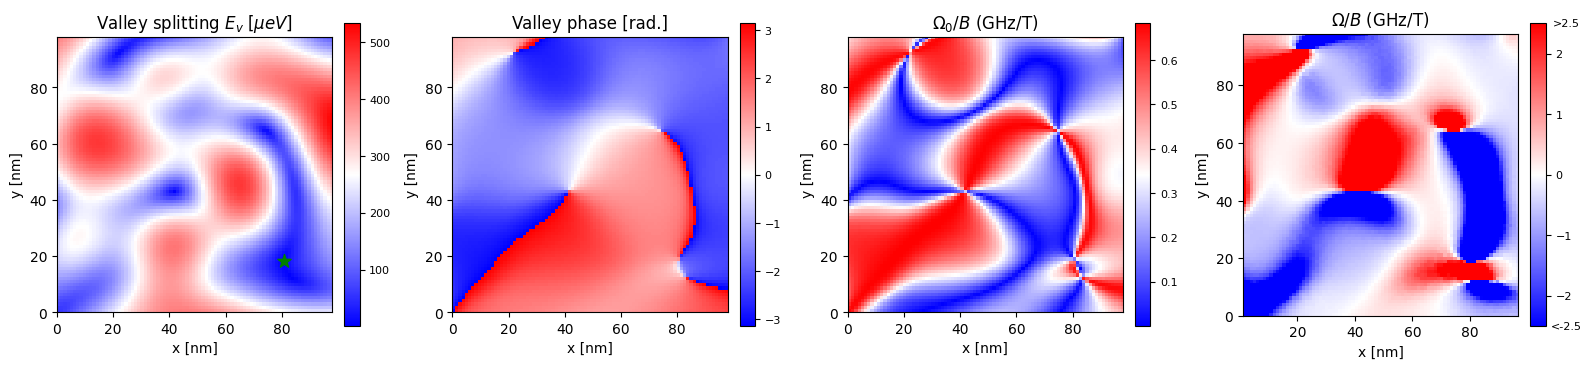

In [34]:
well_potential = V_l()
    
for F_z in [5]: #[1, 3, 5, 7, 9]:
    print(f'Electric field : {F_z} mV/nm')
    electric_potential_ = electric_potential(F_z = F_z)

    Delta_map = np.zeros((N_t, N_t, 4))
    Rabi_vals = np.zeros((N_t, N_t, 2)) 

    for i, x0 in enumerate(x): 
        for j, y0 in enumerate(y): 

            gs = get_groundstate(z_values, well_potential=well_potential, disorder=V_0000[i, j, :], electric_noise=0, electric_potential=electric_potential_)
            
            Delta_0000 = expectation_value((well_potential+ V_0000[i, j, :]) *np.exp((0-1j)*2*k_0*z_values), ground_state=gs)
            Delta_1000 = expectation_value((well_potential+ V_1000[i, j, :]) *np.exp((0-1j)*2*k_0*z_values), ground_state=gs)
            
            Delta_map[i, j, 0]+= Delta_0000[0]
            Delta_map[i, j, 1]+= Delta_0000[1]
            
            Delta_map[i, j, 2]+= Delta_1000[0]
            Delta_map[i, j, 3]+= Delta_1000[1]
            
            
            beta =expectation_value(beta_0*np.exp((0+1j)*2*k_1*z_values), ground_state=gs)
            
            Omega_0 =calculate_Rabi_freq(Delta_0000, Delta_1000, beta, mode='simple')/10**9/B #GHz/T 
            Omega_dipole=calculate_Rabi_freq(Delta_0000, Delta_1000, beta, mode='simple_dipole')/10**9/B #GHz/T
            Rabi_vals[i, j, 0]+= Omega_0
            Rabi_vals[i, j, 1]+=Omega_dipole
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # (rows, cols)

    ax = axes [0]
    im = ax.imshow(2*Delta_map[:, :, 0].T*10**3, cmap="bwr", origin="lower", extent=[0, x.max(), 0, y.max()])
    x_points, y_points = np.where(Delta_map[: ,:, 0] <10**(-3)) 
    ax.scatter(x_points*a_t_, y_points*a_t_, color="green", marker="*", s=100)
    ax.set_title('Valley splitting '+r'$E_v\;[\mu eV]$')
    ax.set_xlabel("x [nm]")
    ax.set_ylabel("y [nm]")
    cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

    ax = axes[1]
    im = ax.imshow(Delta_map[:, :, 1].T, cmap="bwr", origin="lower", extent=[0, x.max(), 0, y.max()])
    # x_points, y_points = np.where(np.abs((np.abs(Delta_map[: ,:, 1])- np.pi/2))<10**(-4)) 
    # ax.scatter(x_points*a_t_, y_points*a_t_, color="green", marker="*", s=100)

    ax.set_title('Valley phase [rad.]')#+r'$E_v\;[\mu eV]$')
    ax.set_xlabel("x [nm]")
    ax.set_ylabel("y [nm]")
    cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

    ax = axes[2]
    im = ax.imshow(np.abs(Rabi_vals[:, :, 0]).T, cmap="bwr", origin="lower", extent=[0, x.max(), 0, y.max()])
    ax.set_title(r'$\Omega_0/B$'+' (GHz/T)')
    ax.set_xlabel("x [nm]")
    ax.set_ylabel("y [nm]")
    cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=8)


    ax = axes[3]
    Omega = Rabi_vals[:, :, 1].copy()
    Omega[Omega>2.5]=2.5
    Omega[Omega<-2.5]=-2.5
    im = ax.imshow(Omega[1:-1,:].T, cmap="bwr", origin="lower", extent=[a_t_, x.max()-a_t_, 0, y.max()])

    ax.set_title(r'$\Omega/B$'+' (GHz/T)')
    ax.set_xlabel("x [nm]")
    ax.set_ylabel("y [nm]")
    cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.05, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.text(2.4, 1, '>2.5', fontsize=8, va='center', ha='center', transform=cbar.ax.transAxes)
    cbar.ax.text(2.4, 0, '<-2.5', fontsize=8, va='center', ha='center', transform=cbar.ax.transAxes)


    plt.tight_layout() 
    plt.show()
    

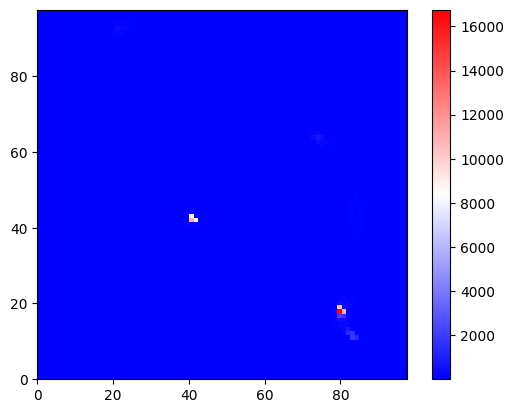

In [35]:
Omega = Rabi_vals[:, :, 1]

der_Omega_x = (Omega[1:, 1:] - Omega[:-1, 1:])/a_t_
der_Omega_y = (Omega[1:, 1:] - Omega[1:, :-1])/a_t_

# b_map = np.zeros_like(der_Omega_x)
# b_map += 4*(der_Omega_x>0) * (der_Omega_y>0)
# b_map += 3*(der_Omega_x<=0) * (der_Omega_y>0)
# b_map += 2*(der_Omega_x>0) * (der_Omega_y<=0)
# b_map += 1*(der_Omega_x<=0) * (der_Omega_y<=0)

der_Omega =np.sqrt(der_Omega_y**2 + der_Omega_x**2 )
# 
x_points, y_points = np.where(der_Omega< 10 **(-12))

plt.scatter(x_points*a_t_, y_points*a_t_, color="green", marker="*", s=100)

plt.imshow(der_Omega.T, cmap="bwr", origin="lower", extent=[0, x.max()-a_t, 0, y.max()-a_t])
plt.colorbar()  # Add colorbar

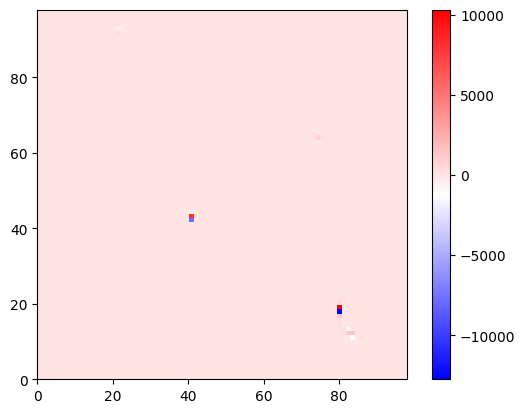

In [36]:
plt.imshow(der_Omega_y.T, cmap="bwr", origin="lower", extent=[0, x.max(), 0, y.max()])
plt.colorbar()

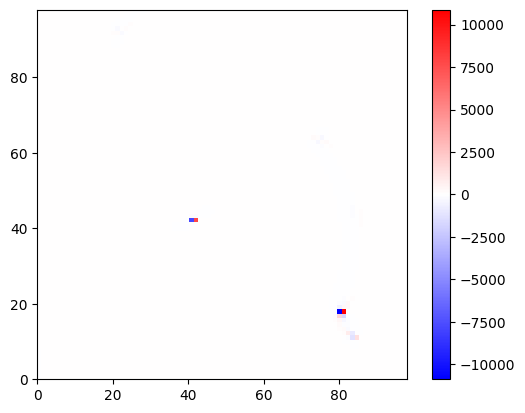

In [37]:
plt.imshow(der_Omega_x.T, cmap="bwr", origin="lower", extent=[0, x.max(), 0, y.max()])
plt.colorbar()